# Introduction
This is an example of a Python notebook used to train a model (K-means Cluster) and then export it as PMML so that it can be easily integrated with additional decision logic.

### Use case: purchase recommendations
In this example end user has bought a series of items (Book, Car, PC) and we want to predict recommendation for his/her next purchase

### Prerequisite
To run this notebook you need to have:
- Python 3 https://www.python.org/downloads/
- Pip https://pypi.org/project/pip/
- jupyter https://jupyter.org/ (`pip install jupyterlab`)

Install dependencies:
- pandas
- scikit-learn
- numpy
- nyoka
- matplotlib

All of them can be installed cloning this repo and using command `pip install -r ./binder/requirements.txt`

Finally start the environment using the command `jupyter notebook`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from nyoka import skl_to_pmml


# Step 1 - Load and prepare data
Data are usually available as unstructure files with text (csv) or binary (parquet, avro) format and there are many libraries to load them from a local or remote storage.

After the loading step it is quite common to perform some preparation/cleanup actions: check domain boundaries, handle missing values, normalize strings, convert enumaration to number, etc.

In [2]:
df = pd.read_csv('input_data.csv')
# splitting buyed_items string to arrays
df.buyed_items = df.buyed_items.str[1:-1].str.replace("'",'').str.replace(",",'').str.split(' ')
# splitting buyed_customer_items_id string to arrays
df.buyed_items_indexes = df.buyed_items_indexes.str[1:-1].str.replace("'",'').str.replace(",",'').str.split(' ')
df.head()

,type,buyed_items,type_index,buyed_items_indexes
0,Book,"[Book-1, Book-2, Book-3, Book-5, Book-8, Book-...",0,"[0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, ..."
1,PC,"[Book-8, Car-3, Car-4, Car-7, PC-0, PC-1, PC-2...",2,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, ..."
2,Book,"[Book-1, Book-5, Book-6, Book-7, Book-8, Book-...",0,"[0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
3,Car,"[Car-0, Car-1, Car-2, Car-3, Car-4, Car-5, Car-8]",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, ..."
4,PC,"[Car-7, PC-0, PC-2, PC-3, PC-4, PC-5, PC-7, PC-8]",2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


# Step 2 - Prepare training set and test set
When a model is trained, it is important to use different set of data to train and test it

In [3]:
# load required columns
inputs = df['buyed_items_indexes']
outputs = df['type']
# splitting buyed_customer_items_id array to multiple columns
inputs_multicolumn  = pd.DataFrame(inputs.tolist(), index=inputs.index)
            
# splitting data in training/test   
test_size = 0.4             # percentage of data used to create test set
random_state = 23           # fixed seed to make randomization reproducible
input_train, input_test, output_train, output_test = train_test_split(inputs_multicolumn, outputs, test_size=test_size, random_state=random_state)             



# Step 3 - Train the model
There are many different models that can be used. In this example we will use a KMeans cluster classifier

In [4]:
pipeline = Pipeline([
    ("classifier", KMeans(n_clusters=3, random_state=0))
])
trained_model = pipeline.fit(input_train)

# Step 4 - Test the mode

There are multiple way to test the model, first of all you should test it using test data

In [5]:
model_score = trained_model.score(input_test)
print("model_score: " + str(model_score))

model_score: -1626.7613477124366


Note: Pay attention to overfitting problem ( https://en.wikipedia.org/wiki/Overfitting )  while you train and test your model. For example a score of 0.99 or similar is an important sign of a probable overfit.

Additionally you can print to visually compare predicted data with real data

In [6]:
predictions = trained_model.predict(input_test)
results = pd.DataFrame({'cluster prediction': predictions.astype(int), 'buyer group': output_test})
results.head()


,cluster prediction,buyer group
519,1,Car
837,2,Book
208,0,PC
525,1,Car
978,0,PC


Another approach is to plot predicted data on chart

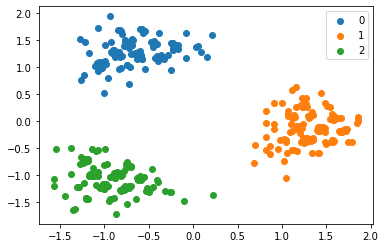

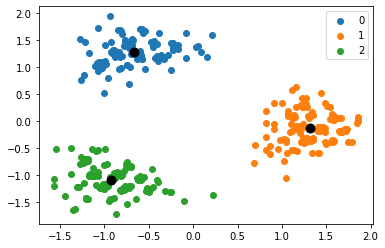

In [7]:
#reduce the number of dimensions so that we can visualize the results using a 2D Scatter plot.
pca = PCA(2)
#Transform the data
df = pca.fit_transform(input_test)

df.shape

#Initialize the class object
kmeans =  KMeans(n_clusters=3, random_state=0)

#predict the labels of clusters.
label = kmeans.fit_predict(df)

filtered_label0 = df[label == 0]
filtered_label1 = df[label == 1]
filtered_label2 = df[label == 2]

#plotting the results
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1], label = 0)
plt.scatter(filtered_label1[:,0] , filtered_label1[:,1], label = 1)
plt.scatter(filtered_label2[:,0] , filtered_label2[:,1], label = 2)
plt.legend()
plt.show()

#plotting centroids
#Getting the Centroids
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()




Scoring and visualization are just simple ways to test the trained model. They are usually not enough for real world use cases.

There are advanced way to analyze how the model is performing (i.e. ROC) and there are many other aspects to consider: fairness, explanability, interpretability.

Additional resources:
- https://en.wikipedia.org/wiki/Receiver_operating_characteristic
- https://christophm.github.io/interpretable-ml-book/

# Step 5 - Save the model as PMML
When your are happy with your model you can export it as PMML.

In [8]:
features = inputs_multicolumn.columns
skl_to_pmml(trained_model,col_names=features,target_name="buy_group",pmml_f_name="cluster_buyer_predictor.pmml")